#Задание

Постройте модель, используя архитектуру со свёрточными слоями, для классификации Fashion MNIST. Итоговое качество (accuracy) должно быть не ниже 89,5.

In [ ]:
# Необходимый импорт
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

# Фиксирую воспроизводимость результатов, чтобы иметь возможность проверить влияние изменения каждого параметра
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Устанавливаю возможность использовать графический ускоритель, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Если он доступен и модель обучается на нём, то нижеследующий код позволит всегда получать одинаковые результаты,
# при запуске одинакового кода на одинаковых данных в одной и той же среде (не гарантируется, когда работаю в колабе). 
# В общем, максимально обеспечивает повторяемость результатов.
if device == 'cuda':
    torch.backends.cudnn.deterministic = True
    # Ставлю этот флаг на False, потому что предыдущий - True.
    # Когда benchmark = True, PyTorch будет выбирать максимально оптимизированный алгоритм для обучения на GPU
    # Пока для этого нет необходимости - воспроизводимость результатов важнее.
    torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt

## Загрузка данных

In [ ]:
# Создаю пайплайн для трансформаций датасета сначала в тензоры, а потом нормализация тензоров вокруг среднего 0.5 со стандратным отклонением 0.5
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Загружаю данные из torchvision, сначала обучающий датасет, затем - тестовый
dataset_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataset_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Устанавливаю размер мини-батча
batch_size = 64
# Создаю два загрузчика, в обучающем перемешиваю данные, в тестовом - нет
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Архитектура

In [ ]:
# Сверточная сеть для классификации Fashion MNIST
class FashionConvClass(nn.Module):
    def __init__(self):
        super(FashionConvClass, self).__init__()
        # Первый свёрточный слой на 32 фильтра, каждый фильтр размером 3*3. 
        # Каждый фильтр будет улавливать какие-то свои особенности на оригинальном изображении.
        # Веса у каждого фильтра будут обновляться в результате градиентного спуска.
        # Так паддинг = 1, то результирующая карта фич (32 штуки) будет такого же размера, что и оригинальное изображение
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Перед отправкой в активацию, каждую из карт фич нормализую. После нормализации будет активация ReLU
        self.batch_norm1 = nn.BatchNorm2d(num_features=32)
        # Применяю к каждой нормализованной и активированной карте фич пулинг - этот конкретный выбирает максимальное
        # значение в матрице 2*2, когда проходит по карте фич, и составляет новую карту фич, меньшего размера
        # с более выделенными признаками за счет максимального значения.
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # Дальше 32 карты размером 14*14 (после пулинга) поступают в следующий свёрточный слой,
        # где из них выделяются более абстрактные признаки. В итоге, так как второй свёрточный слой имеет 64 фильтра,
        # получаются еще 64 карты фич, но на этот раз размером 14*14
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Нормализую карты фич, отправляю в ReLU
        self.batch_norm2 = nn.BatchNorm2d(num_features=64)
        # Опять максимальный пулинг, в итоге 64 карты фич получаются размером 7*7 каждая
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # В линейный слой на 512 нодов
        self.linear1 = nn.Linear(in_features=64*7*7, out_features=512)
        # Постараюсь убрать оверфиттинг после этого слоя, чтобы модель хорошо работала в общем, а не на конкретных обучающих данных
        self.dropout1 = nn.Dropout(p=0.5)
        # Еще один полносвязный слой, до него после дропаута была ReLU
        self.linear2 = nn.Linear(in_features=512, out_features=128)
        # Дальше повторяется ситуация с полносвязными слоями, с уменьшением кол-ва нодов
        self.dropout2 = nn.Dropout(p=0.5)
        # После следующего линейного слоя не будет функции активации. Можно было бы использовать софтмакс,
        # но выбранная мною функция потерь прекрасно справится и без этого. И даже лучше, чем с этим.
        self.linear3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Здесь оставила дебаггинг принты, чтобы проверять, какой размерности тензоры путешествуют по сети
        #print(f"Вход: {x.shape}")
        x = nn.ReLU()(self.batch_norm1(self.conv1(x)))
        #print(f"После conv1: {x.shape}")
        x = self.pool1(x)
        #print(f"После pool1: {x.shape}")
        x = nn.ReLU()(self.batch_norm2(self.conv2(x)))
        #print(f"После conv2: {x.shape}")
        x = self.pool2(x)
        #print(f"После pool2: {x.shape}")
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        #print(f"После view до linear1: {x.shape}")
        x = nn.ReLU()(self.linear1(x))
        #print(f"После linear1: {x.shape}")
        x = self.dropout1(x)
        x = nn.ReLU()(self.linear2(x))
        #print(f"После linear2: {x.shape}")
        x = self.dropout2(x)
        x = self.linear3(x)
        #print(f"После linear3 выход: {x.shape}")
        return x

In [ ]:
# Инстанциирую модель
model = FashionConvClass().to(device)
# Проверяю, на чём работаем
print(f"Model device: {next(model.parameters()).device}")

# Функция потерь - кроссэнтропия с логитами
criterion = nn.CrossEntropyLoss()
# Этот оптимизатор лучше всего себя показал, пробовала RMSprop (норм, но медленнее),
# Adam - просто ужас, SGD с моментумом и нестеровым - чуть хуже и медленнее.
optimizer = optim.SGD(model.parameters(), lr=0.1)

Model device: cuda:0


In [ ]:
# Архитектура отдельно
model

FashionConvClass(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# Небольшой чит, проверить, как себя тензоры ведут
'''
x = torch.rand(1, 1, 28, 28).to(device)  # batch_size=1, 1 канал, 28x28 ш*в размер

model.train()
optimizer.zero_grad()
y = model(x)
'''

'\nx = torch.rand(1, 1, 28, 28).to(device)  # batch_size=1, 1 канал, 28x28 ш*в размер\n\nmodel.train()\noptimizer.zero_grad()\ny = model(x)\n'

Результат предыдущей проверки:

- Вход: torch.Size([1, 1, 28, 28])
- После conv1: torch.Size([1, 32, 28, 28])
- После pool1: torch.Size([1, 32, 14, 14])
- После conv2: torch.Size([1, 64, 14, 14])
- После pool2: torch.Size([1, 64, 7, 7])
- После view до linear1: torch.Size([1, 3136])
- После linear1: torch.Size([1, 512])
- После linear2: torch.Size([1, 128])
- После linear3 выход: torch.Size([1, 10])

Соответственно, "в бою" вместо 1 в самом начале тензора будет стоять размер мини-батча, всё остальное соответствует задуманной и описанной архитектуре.

## Обучение

In [ ]:
# Обучаю модель, 15 эпох
num_epochs = 15
# Графички построю тоже
training_accuracy_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    accuracy_train = 0
    
    # Расписывать не буду, тут классика - обнуляю градиенты, предсказываю, оптимизатор считает, обновляет веса
    # Новое по сравнению с прошлой работой - включила в каждую эпоху расчёт точности модели на тестовых данных после отзыва преподавателя
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        accuracy_train += (predicted == labels).sum().item()
    
    training_loss = training_loss / len(train_loader)  
    accuracy_train = 100 * accuracy_train / len(train_loader.dataset)
    training_accuracy_list.append(accuracy_train)
    
    model.eval()
    accuracy_test = 0
    
    # Здесь использую no_grad(), так как при оценке на тесте не надо считать градиенты и обновлять веса
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            accuracy_test += (predicted == labels).sum().item()
    
        accuracy_test = 100 * accuracy_test / len(test_loader.dataset)
        test_accuracy_list.append(accuracy_test)
    
    print(f'Эпоха обучения [{epoch+1}/{num_epochs}], Потеря: {training_loss:.4f}, Точность обучения: {accuracy_train:.2f}%, Точность на тестовых данных: {accuracy_test:.2f}%\n')

Эпоха обучения [1/15], Потеря: 0.5748, Точность обучения: 79.28%, Точность на тестовых данных: 83.94%

Эпоха обучения [2/15], Потеря: 0.3780, Точность обучения: 86.61%, Точность на тестовых данных: 88.19%

Эпоха обучения [3/15], Потеря: 0.3231, Точность обучения: 88.33%, Точность на тестовых данных: 90.13%

Эпоха обучения [4/15], Потеря: 0.2903, Точность обучения: 89.66%, Точность на тестовых данных: 89.31%

Эпоха обучения [5/15], Потеря: 0.2663, Точность обучения: 90.34%, Точность на тестовых данных: 89.70%

Эпоха обучения [6/15], Потеря: 0.2432, Точность обучения: 91.31%, Точность на тестовых данных: 89.94%

Эпоха обучения [7/15], Потеря: 0.2277, Точность обучения: 91.77%, Точность на тестовых данных: 91.49%

Эпоха обучения [8/15], Потеря: 0.2123, Точность обучения: 92.36%, Точность на тестовых данных: 91.74%

Эпоха обучения [9/15], Потеря: 0.2010, Точность обучения: 92.70%, Точность на тестовых данных: 91.34%

Эпоха обучения [10/15], Потеря: 0.1896, Точность обучения: 93.14%, Точнос

# Графики и вывод

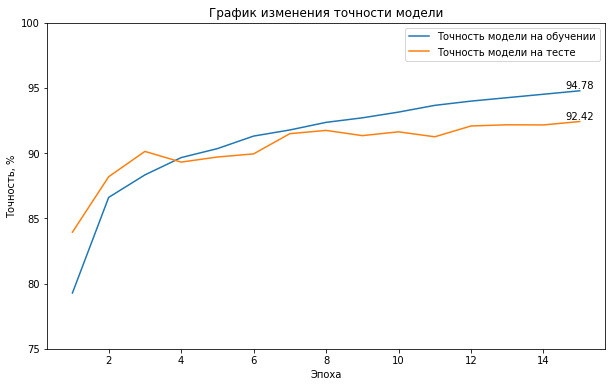

In [ ]:
# Небольшой графичек - наглядно помогает выбрать лучшую для данной задачи архитектуру
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), training_accuracy_list, label='Точность модели на обучении')
plt.plot(range(1, 16), test_accuracy_list, label='Точность модели на тесте')

# Добавляю финальные значения точности модели на 15 эпохе
plt.annotate(str(round(training_accuracy_list[-1], 2)), xy=(15, training_accuracy_list[-1]), ha='center', va='bottom')
plt.annotate(str(test_accuracy_list[-1]), xy=(15, test_accuracy_list[-1]), ha='center', va='bottom')

plt.title('График изменения точности модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность, %')

# Не удержалась - поставила лимит для оси, чтобы приблизить графики и отследить изменение точности в больше масштабе
plt.ylim([75, 100])
plt.legend()

plt.show()

**Вывод**

В целом модель обучалась быстро, у меня была возможность проверить несколько архитектур - выбрала самую перспективную. Однако, введение второго свёрточного слоя увеличило время обучения вдвое, при этот точность модели возросла всего на 1%. В моём случае это была интересная практика, в реальных условиях я вряд ли добавила бы второй свёрточный слой.

И наконец-то переключение на GPU дало свои плоды. Колоссальная экономия времени обучения модели - что неудивительно, ведь GPU идеален для свёрток.